In [1]:
library(Seurat)
seurat = readRDS('ln_seurat.RDS')
tcr = readRDS('TCR/tcrmeta.RDS')
hashmeta = readRDS('cell hashing/hashed_metadata.RDS')


Loading required package: ggplot2

Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Loading required package: cowplot


********************************************************

Note: As of version 1.0.0, cowplot does not change the

  default ggplot2 theme anymore. To recover the previous

  behavior, execute:
  theme_set(theme_cowplot())

********************************************************


Loading required package: Matrix



In [2]:
seurat

An object of class seurat in project SeuratProject 
 14458 genes across 17387 samples.

In [3]:
seurat@meta.data$id = paste0(seurat@meta.data$orig, seurat@meta.data$bc)
rownames(tcr) = paste0(tcr$orig, tcr$bc)
rownames(hashmeta) = paste0(hashmeta$orig, hashmeta$bc)
tcr_cols = colnames(tcr)[10:21]
seurat@meta.data[,tcr_cols] = tcr[seurat@meta.data$id,tcr_cols]
seurat@meta.data$hash = hashmeta[seurat@meta.data$id, 'hash']


In [4]:
source("L:/Duncan/kptumors_figures/figure_parameters.R")
Axis_themes = Axis_themes + theme(plot.title = element_text(size = 8),
                     axis.title = element_text(size = 8), 
                     axis.text = element_text(size = 6),
                     axis.text.x = element_text(size = 6),
                     legend.text = element_text(size =6),
                     legend.title = element_text(size = 8),
                     strip.text.x = element_text(size = 8), 
                     axis.line =element_line(size = .11167), 
                     axis.ticks = element_line(size = .11167)) 

UMAP_theme = theme_bw()+theme(axis.text.y = element_blank(), 
                               axis.text.x = element_blank(), 
                               axis.ticks.x= element_blank(),
                               axis.ticks.y= element_blank(),
                               axis.title.x= element_blank(),
                               axis.title.y= element_blank(),
                               strip.text.x = element_text(size = 8),
                               panel.grid.major = element_blank(),
                               panel.grid.minor = element_blank(),
                               panel.border = element_blank(),
                               panel.background = element_rect(colour = "black", fill = NA,size=.25),
                               legend.position = "none",
                               plot.title = element_text(hjust = 0.5, size = 8))

In [5]:
seurat = SubsetData(seurat, seurat@cell.names[!seurat@meta.data$hash %in% c('Negative', 'Doublet')], subset.raw = TRUE)
seurat

An object of class seurat in project SeuratProject 
 14458 genes across 16249 samples.

In [6]:
summary(seurat@meta.data$n_genes)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    697     857    1087    1306    1511    7180 

In [7]:
library(ggthemes)
library(RColorBrewer)
tissue_palette = c('#FF2600', '#FF7E79', '#0433FF', '#0095FF')
phenotype_palette =ggthemes_data[['tableau']][['color-palettes']]$regular$`Tableau 10`$value

names(tissue_palette) = c('Flank_tdLN', 'Flank_naiveLN', 'Lung_tdLN', 'Lung_naiveLN')



Attaching package: 'ggthemes'


The following object is masked from 'package:cowplot':

    theme_map




In [8]:
options(repr.plot.res =300, repr.plot.width = 2, repr.plot.height = 2)
source("L:/Duncan/kptumors_figures/functions.R")
seurat = pyProcess(seurat)



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Regressing out: n_genes




Time Elapsed:  56.6942138671875 secs

Scaling data matrix

Warning message:
"Python 'C:\Users\dmorgan\AppData\Local\Continuum\anaconda3\envs\seqwell\python.exe' was requested but 'C:/Users/dmorgan/AppData/Local/r-miniconda/envs/r-reticulate/python.exe' was loaded instead (see reticulate::py_config() for more information)"


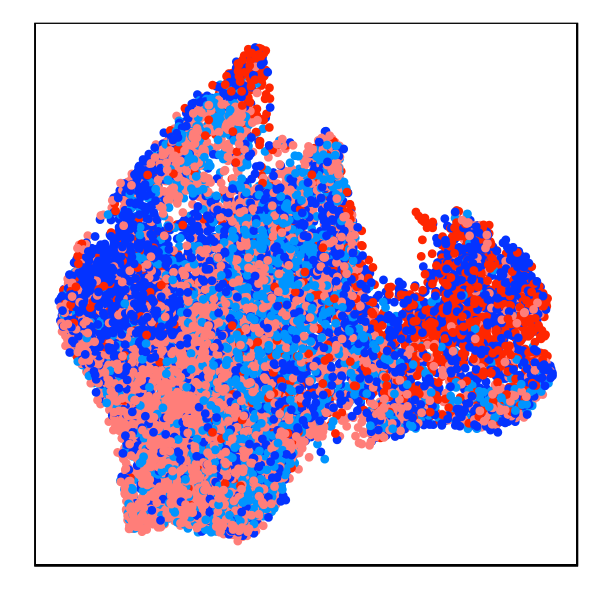

In [9]:
options(repr.plot.width = 2, repr.plot.height = 2, repr.plot.res = 300)
seurat@meta.data$sample = paste0(seurat@meta.data$location, '_', seurat@meta.data$condition)
seurat@meta.data$sample = factor(seurat@meta.data$sample, levels = c('Lung_tdLN', 'Flank_tdLN', 'Lung_naiveLN', 'Flank_naiveLN'))

seurat = addUMAP(seurat)
g1 = ggplot(shuffle(seurat@meta.data), aes(x = UMAP1, y =UMAP2, color = sample))+ geom_point(size = .1) + theme_classic() + Axis_themes + UMAP_theme + guides(color = FALSE) + 
scale_color_manual(values = tissue_palette) + theme(panel.border = element_rect(fill=NA, colour = "black", size=.11671)) 

g1
ggsave('umap_all.pdf', height = 2, width = 2, useDingbats = FALSE)

In [10]:
seurat = RunPCA(seurat, pcs.compute = 50, do.print = FALSE)
seurat = FindClusters(seurat, resolution = .14, dims.use = 1:20, print.output = FALSE, force.recalc = TRUE)


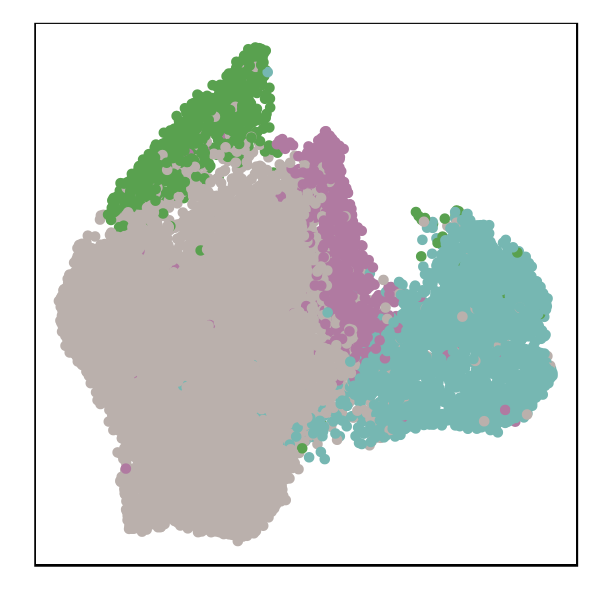

In [11]:
c1_palette =ggthemes_data[['tableau']][['color-palettes']]$regular$`Tableau 10`$value[c(10,4,5,7)]
g2 = ggplot(shuffle(seurat@meta.data), aes(x = UMAP1, y = UMAP2, color = res.0.14)) + geom_point(size = .3) + guides(color = FALSE) + theme_classic() + Axis_themes + UMAP_theme + 
scale_color_manual(values = c1_palette)

g2

Warning message:
"Removed 4 rows containing missing values (geom_point)."


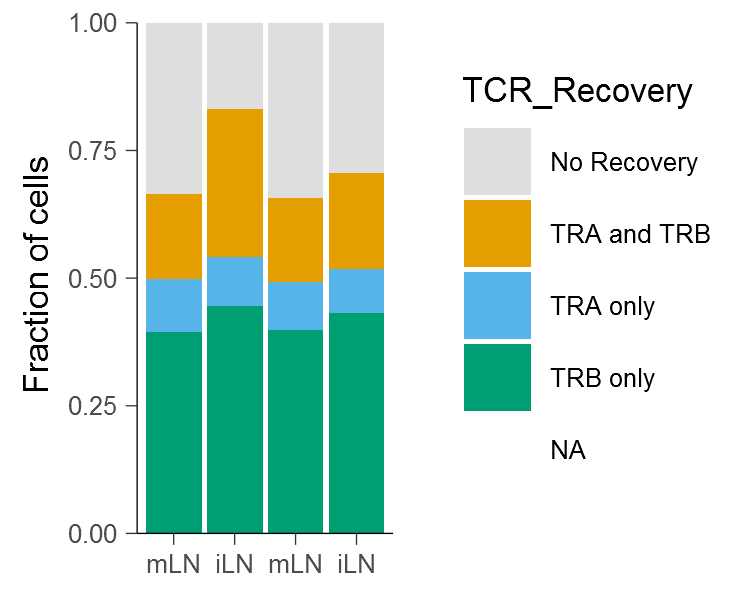

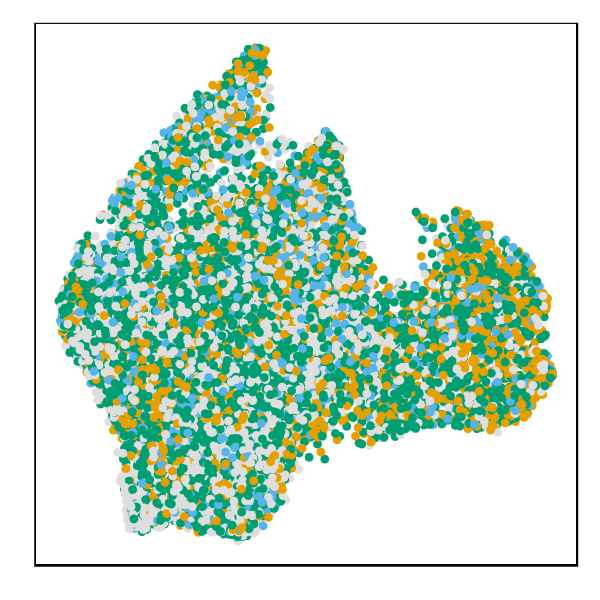

In [12]:
options(repr.plot.width = 2.5, repr.plot.height =2 )
g3 = ggplot(seurat@meta.data, aes(x = sample, fill = TCR_Recovery)) + geom_bar(position = 'fill') + scale_fill_manual(values = cbPalette) + theme_classic() + Axis_themes +
scale_x_discrete(labels = c('mLN', 'iLN', 'mLN', 'iLN')) + labs(x = c(), y = 'Fraction of cells') + scale_y_continuous(expand = c(0,0))
g3
options(repr.plot.width = 2, repr.plot.height =2 )
g4 = ggplot(shuffle(seurat@meta.data), aes(x = UMAP1, y = UMAP2, color = TCR_Recovery)) + geom_point(size = 0.1) + scale_color_manual(values = cbPalette) + theme_classic() + UMAP_theme
g4

In [13]:
table(seurat@meta.data$TCR_Recovery)


No Recovery TRA and TRB    TRA only    TRB only 
       4945        3049        1524        6727 

In [14]:
(6660+2341)/16249
(1419+2341)/16249

2341/16249

[1] 0.5539418

[1] 0.2313989

[1] 0.1440704

In [15]:
library(fgsea)
library(GSA)
library(stringr)
set.seed(1)
gene.sets = GSA.read.gmt("gse14308.gmt")
for (i in 1:length(gene.sets$geneset.names)) {
  seurat = AddModuleScore(seurat, genes.list =list(genes = str_to_title(gene.sets[[1]][i][[1]])), enrich.name = gene.sets$geneset.names[i])
}

gene.sets = GSA.read.gmt("gse11057.gmt")
for (i in 1:length(gene.sets$geneset.names)) {
  seurat = AddModuleScore(seurat, genes.list =list(genes = str_to_title(gene.sets[[1]][i][[1]])), enrich.name = gene.sets$geneset.names[i])
}

gene.sets = GSA.read.gmt("gse15659.gmt")
for (i in 1:length(gene.sets$geneset.names)) {
  seurat = AddModuleScore(seurat, genes.list =list(genes = str_to_title(gene.sets[[1]][i][[1]])), enrich.name = gene.sets$geneset.names[i])
}


Loading required package: Rcpp



1234567891011121314151617181920212223242526272829301
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
123456789101112131415161
2
3
4
5
6
7
8
9
10
11
12
13
14
15
123456789101112131415161718192021221
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


Loading required package: magrittr


Attaching package: 'ggpubr'


The following object is masked from 'package:cowplot':

    get_legend




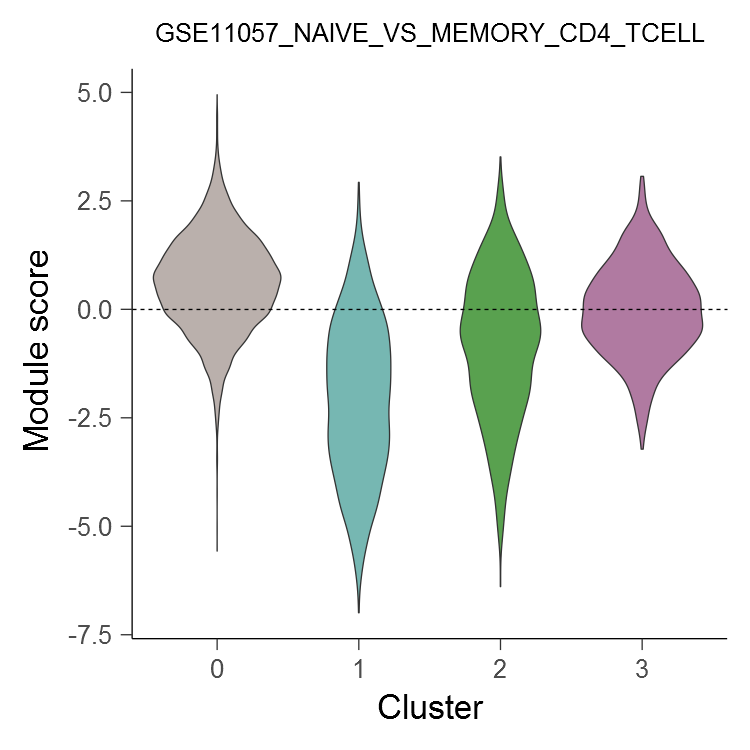

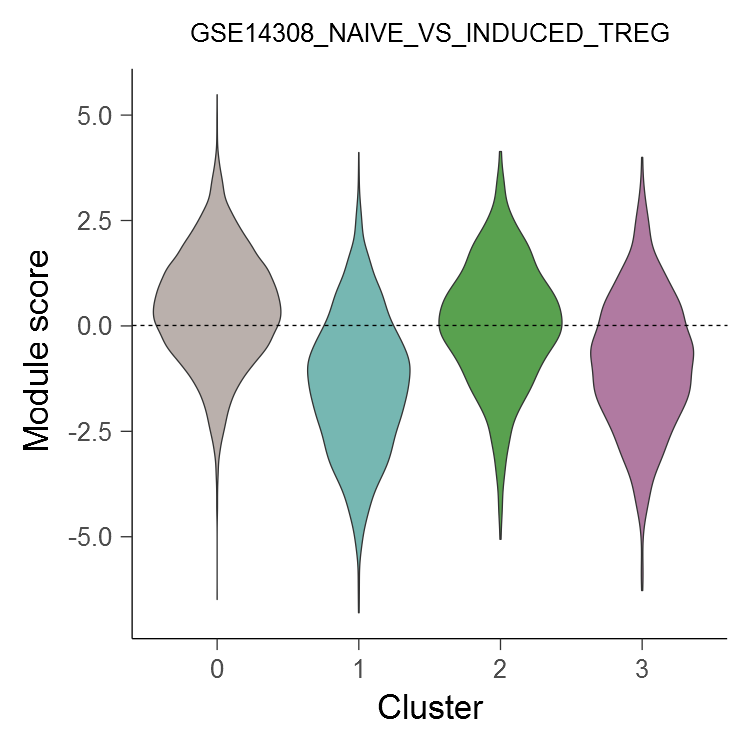

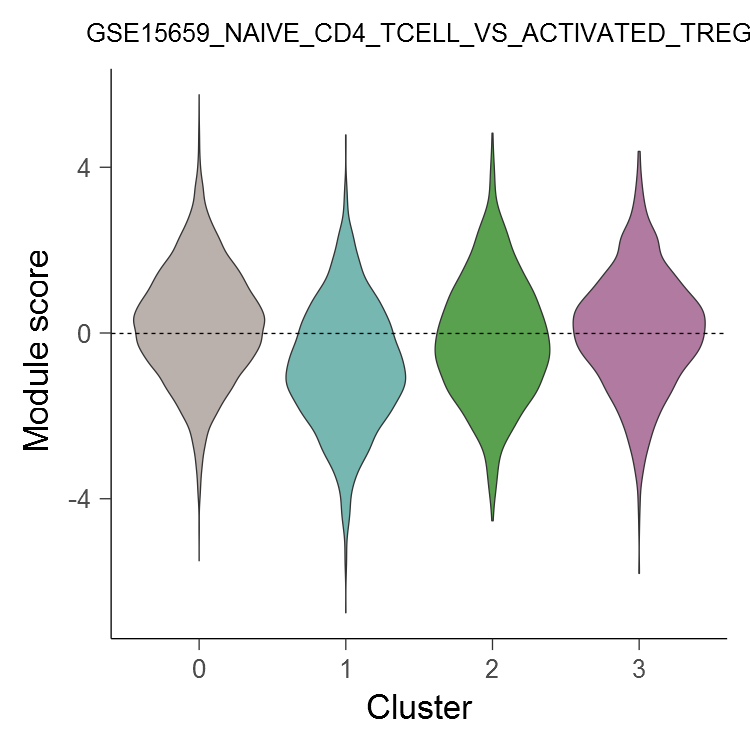

In [16]:
library(ggpubr)
options(repr.plot.width = 2.5, repr.plot.height = 2.5)


g5= ggplot(seurat@meta.data,aes( x= res.0.14, y = scale(GSE11057_NAIVE_VS_MEMORY_CD4_TCELL_UP1) - scale(GSE11057_NAIVE_VS_MEMORY_CD4_TCELL_DN1), fill =  res.0.14)) + geom_violin(size = .11167) + theme_classic() + Axis_themes + 
#stat_compare_means(comparisons = list(c(1,2), c(1,3), c(1,4)), label = 'p.signif')  + 
guides(fill = FALSE) + geom_hline(yintercept = 0, linetype = 'dashed', size = .11167) + 
scale_fill_manual(values = c1_palette) + labs(y = 'Module score', x = 'Cluster') + ggtitle('GSE11057_NAIVE_VS_MEMORY_CD4_TCELL')+ theme(plot.title = element_text(size = 6, hjust = .5))
g5

g6 = ggplot(seurat@meta.data,aes( x= res.0.14, y = scale(GSE14308_NAIVE_CD4_TCELL_VS_INDUCED_TREG_UP1) - scale(GSE14308_NAIVE_CD4_TCELL_VS_INDUCED_TREG_DN1), fill =  res.0.14)) + geom_violin(size = .11167) + theme_classic() + Axis_themes + 
#stat_compare_means(comparisons = list(c(1,2), c(1,3), c(1,4)), label = 'p.signif')  + 
guides(fill = FALSE) +geom_hline(yintercept = 0, linetype = 'dashed', size = .11167) +
scale_fill_manual(values = c1_palette) + labs(y = 'Module score', x = 'Cluster') + ggtitle('GSE14308_NAIVE_VS_INDUCED_TREG')+ theme(plot.title = element_text(size = 6, hjust = .5))
g6

g7 = ggplot(seurat@meta.data,aes( x= res.0.14, y = scale(GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_UP1) - scale(GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG_DN1), fill =  res.0.14)) + geom_violin(size = .11167) + theme_classic() + Axis_themes + 
#stat_compare_means(comparisons = list(c(1,2), c(1,3), c(1,4)), label = 'p.signif')  + 
guides(fill = FALSE) +geom_hline(yintercept = 0, linetype = 'dashed', size = .11167) +
scale_fill_manual(values = c1_palette) + labs(y = 'Module score', x = 'Cluster')  + ggtitle('GSE15659_NAIVE_CD4_TCELL_VS_ACTIVATED_TREG') + theme(plot.title = element_text(size = 6, hjust = .5))
g7

ggsave('violin3.pdf', height =2, width = 2, useDingbats = FALSE)

character(0)

Loading required package: viridisLite


Attaching package: 'viridis'


The following object is masked from 'package:viridisLite':

    viridis.map




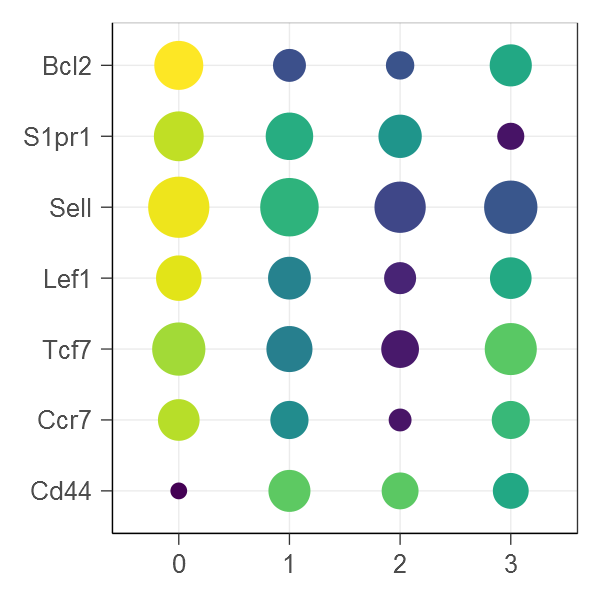

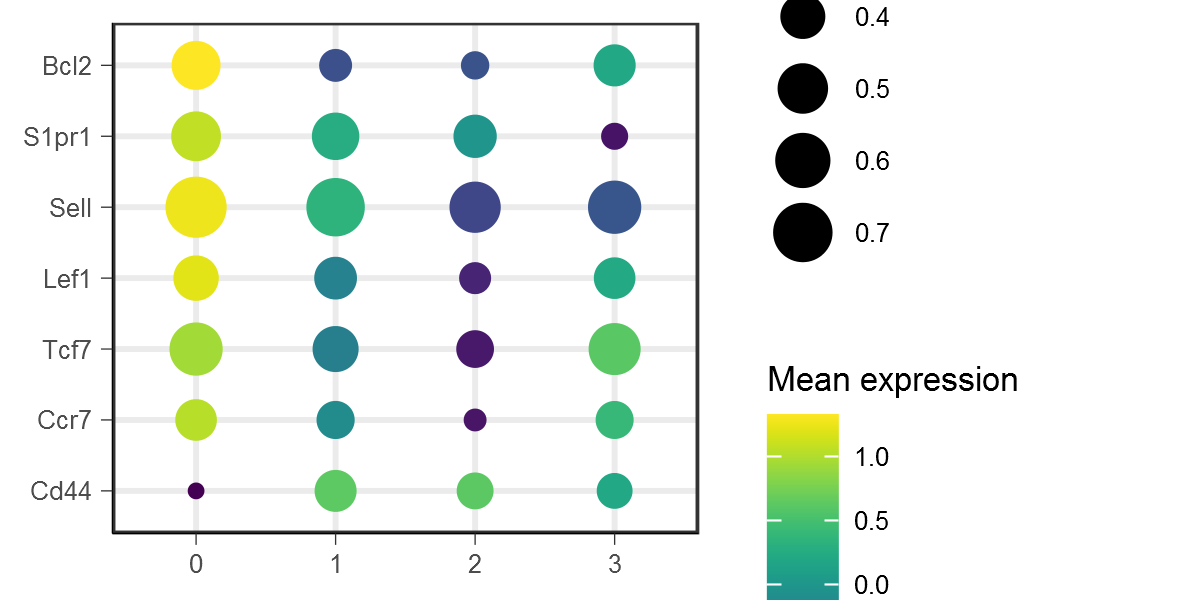

In [17]:
library(dplyr)
#genes = c("Cd3e", 'Cd4', 'Foxp3', 'Il2ra', 'Bcl2', 'S1pr1', 'Sell', 'Lef1', 'Tcf7', 'Ccr7', 'Mki67', 'Top2a','Tubb5', 'Lgals1','Icos', 'Ctla4', 'Cd28', 'Calm3', 'Calm1', 'Calr', 'Itgb1', 'Itgae', 'Cd44', 'Cd69')
genes = c('Bcl2', 'S1pr1', 'Sell', 'Lef1', 'Tcf7', 'Ccr7', 'Cd44')
genes[!genes %in% rownames(seurat@data)]

options(repr.plot.width = 2, repr.plot.height = 2)
pct = function(x) {
  sum(x >0)/length(x)
}
meanexp = function(x) {
    mean(x)
}
library(reshape2)
library(viridis)
data = as.data.frame(t(as.matrix(seurat@data[genes,])))
data$phenotype = seurat@meta.data$res.0.14
df_exp = data %>% group_by(phenotype) %>% summarize_all(.funs = list(meanexp)) %>% as.data.frame() 
df_exp[,2:(1+length(genes))] = scale(df_exp[,2:(1+length(genes))])
df_exp = df_exp %>% melt(id.vars = 'phenotype')
df_pct = data %>% group_by(phenotype) %>% summarize_all(.funs = list(pct)) %>% melt(id.vars = 'phenotype')
df_exp$value[df_exp$value > 2]= 2
df_exp$value[df_exp$value < -1.5]= -1.5
df_exp$pct = df_pct$value


lvs = levels(factor(df_exp$phenotype))
g8 = ggplot(as.data.frame(df_exp), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 
 theme_bw()  + theme(axis.title = element_blank()) + 
labs(color = "Mean expression", size = 'Fraction of cells expressing') + scale_x_discrete(limits = rev(genes)) + Axis_themes + 
theme(axis.title = element_blank(), axis.text = element_text(size = 6)) + scale_y_discrete(limits = (lvs), labels = c('0', 1,2,3)) + guides(size = FALSE, color = FALSE) + coord_flip()  +
theme(panel.background = element_rect(size = .11671), panel.border = element_rect(size = .11671), panel.grid.major = element_line(size = .11671), panel.grid.minor = element_line(size = .11671))
#theme( axis.text.x = element_text(angle = 45, hjust = 1))
g8

options(repr.plot.width = 4, repr.plot.height = 2)

ggplot(as.data.frame(df_exp), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 
 theme_bw()  + theme(axis.title = element_blank()) + 
labs(color = "Mean expression", size = 'Fraction of cells expressing') + scale_x_discrete(limits = rev(genes)) + Axis_themes + 
theme(axis.title = element_blank(), axis.text = element_text(size = 6)) + scale_y_discrete(limits = (lvs), labels = c('0', 1,2,3))+ coord_flip() #theme( axis.text.x = element_text(angle = 45, hjust = 1))

In [18]:
a = FindMarkers(seurat, 0)
write.csv(a, 'naive_markers.csv')

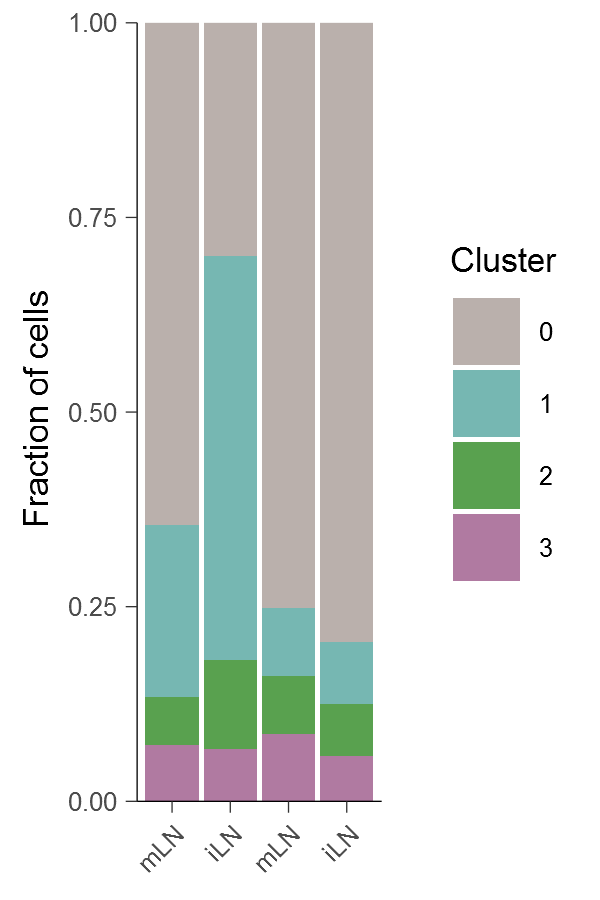

In [19]:
options(repr.plot.width = 2, repr.plot.height = 3)
g9 = ggplot(seurat@meta.data, aes( x= sample, fill = factor(res.0.14))) + geom_bar(position = 'fill') + scale_fill_manual(values = c1_palette) + 
theme_classic() + Axis_themes + labs(x = c(), y = 'Fraction of cells', fill = 'Cluster') + 
scale_y_continuous(expand = c(0,0)) + theme(axis.text.x = element_text(angle = 45, hjust = 1)) + scale_x_discrete(labels = c('mLN', 'iLN', 'mLN', 'iLN'))

g9

In [20]:
seurat2 = SubsetData(seurat, seurat@cell.names[seurat@meta.data$res.0.14 != 0])
seurat2 = pyProcess(seurat2)
seurat2 = addUMAP(seurat2)

Regressing out: n_genes




Time Elapsed:  31.8841979503632 secs

Scaling data matrix



In [21]:
seurat2

An object of class seurat in project SeuratProject 
 14458 genes across 5104 samples.

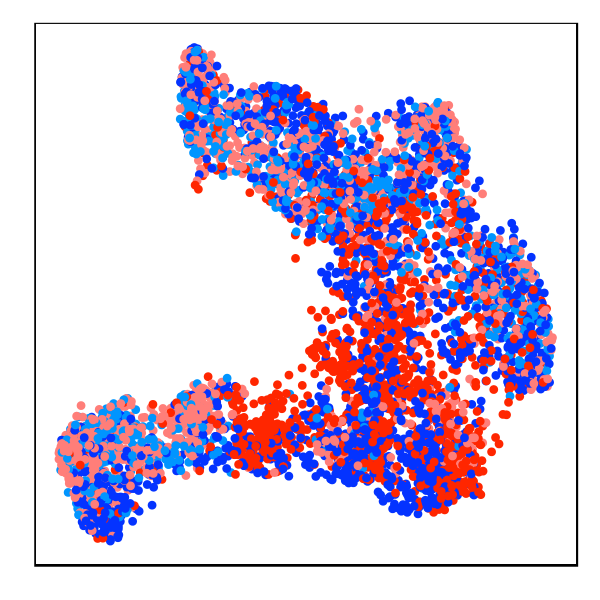

In [22]:
options(repr.plot.res =300, repr.plot.width = 2, repr.plot.height = 2)

g10 = ggplot(shuffle(seurat2@meta.data), aes(x = UMAP1, y =UMAP2, color = sample))+ geom_point(size = .1) + theme_classic() + Axis_themes + UMAP_theme + guides(color = FALSE) + 
scale_color_manual(values = tissue_palette)

g10

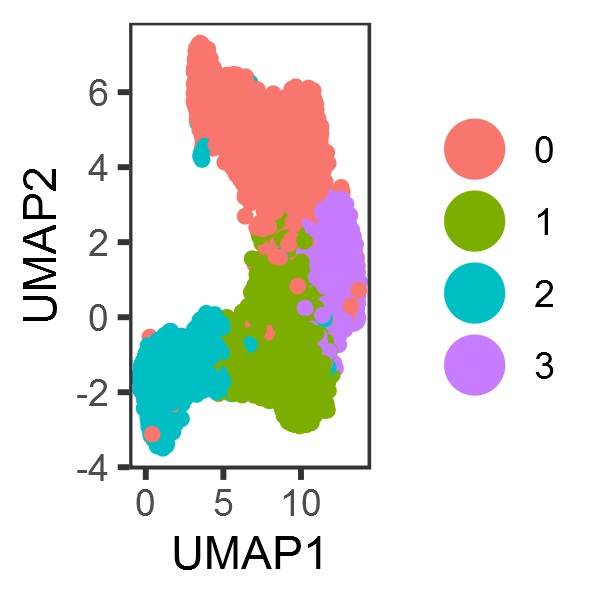

In [23]:
seurat2 = FindClusters(seurat2, resolution = .2, dims.use = 1:20, print.output = FALSE, force.recalc = TRUE)
DimPlot(seurat2, 'umap')

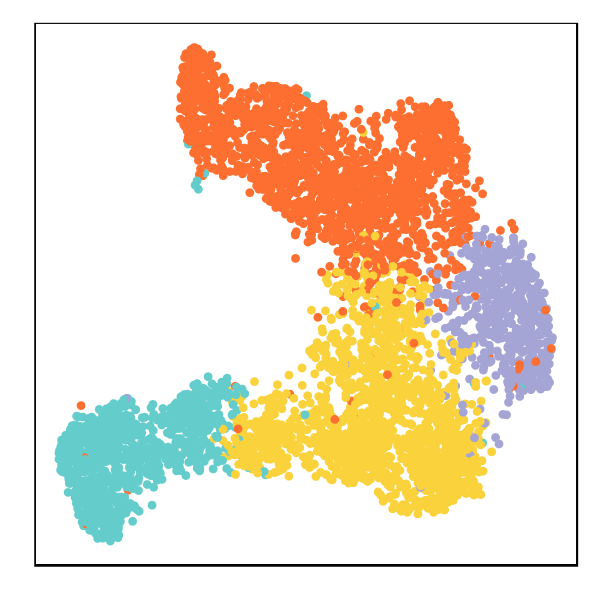

In [24]:
options(repr.plot.res =300, repr.plot.width = 2, repr.plot.height = 2)
phenotype_palette =ggthemes_data[['tableau']][['color-palettes']]$regular$`Jewel Bright`$value[c(2,4,6,8)]

#seurat2 = FindClusters(seurat2, resolution = .2, dims.use = 1:20, print.output = FALSE, force.recalc = TRUE)

g11 = ggplot(shuffle(seurat2@meta.data), aes(x =UMAP1, y = UMAP2, color = res.0.2)) + geom_point(size = .1) + scale_color_manual(values = phenotype_palette) + theme_classic() + guides(color = FALSE) + 
UMAP_theme
g11

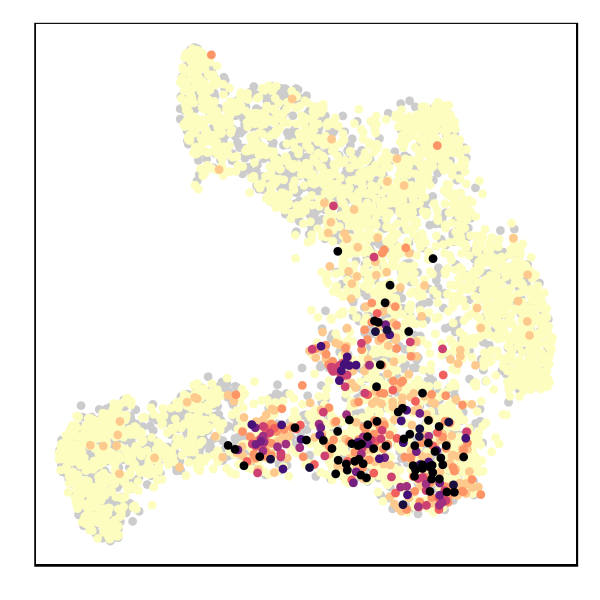

In [25]:
options(repr.plot.height = 2, repr.plot.width = 2)
library(stringr)
seurat2@meta.data$CDR3_junction = sapply(seurat2@meta.data$TRB_nuc, function(x) substring(x, 4, str_length(x)-3))


seurat2@meta.data$trbid = paste0(seurat2@meta.data$location, seurat2@meta.data$hash, seurat2@meta.data$CDR3_junction)
seurat2@meta.data$trbid[is.na(seurat2@meta.data$TRB_CDR3)] = NA
tab = table(seurat2@meta.data$trbid)
seurat2@meta.data$trb_count = as.numeric(tab[seurat2@meta.data$trbid])

seurat2@meta.data$trb_factor = as.character(seurat2@meta.data$trb_count)
seurat2@meta.data$trb_factor[seurat2@meta.data$trb_count > 9] = '10+'
seurat2@meta.data$trb_factor =factor(seurat2@meta.data$trb_factor, levels = c(1, 2, 3, 4, 5,6, 7, 8,9, '10+'))

trb_size_palette = rev(viridis(10, option = 2))
names(trb_size_palette) = levels(seurat2@meta.data$trb_factor)

g12 = ggplot(seurat2@meta.data %>% filter(is.na(TRB_CDR3)), aes(x = UMAP1, y =UMAP2)) + geom_point(size = .1, color = 'grey80') + 
geom_point(data = seurat2@meta.data %>% filter(!is.na(TRB_CDR3)) %>% arrange(trb_count), aes(color = trb_factor), size = .1) + scale_color_manual(values = trb_size_palette) +
theme_classic() + guides(color = FALSE) + UMAP_theme
                                         
g12

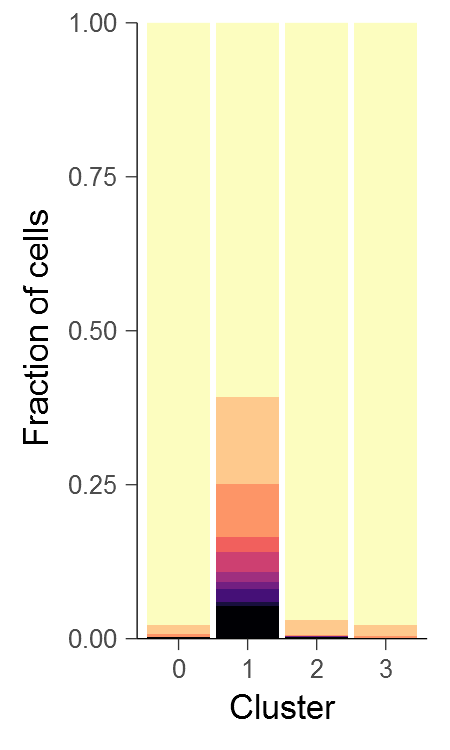

In [26]:
options(repr.plot.height = 2.5, repr.plot.width = 1.5)
g13 = ggplot(seurat2@meta.data %>% filter(!is.na(TRB_CDR3)), aes(x = res.0.2, fill = trb_factor)) + geom_bar(position = 'fill') + guides(fill = FALSE) + theme_classic() + 
scale_y_continuous(expand = c(0,0)) +
Axis_themes + labs(x = 'Cluster', y = 'Fraction of cells') + scale_fill_manual(values = trb_size_palette)

g13


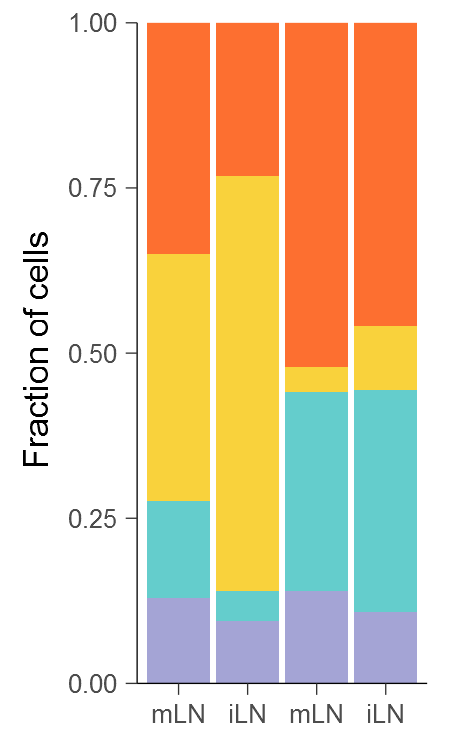

In [27]:
options(repr.plot.height = 2.5, repr.plot.width = 1.5)

g14 = ggplot(seurat2@meta.data, aes(x = sample, fill = res.0.2)) + geom_bar(position = 'fill')+ scale_fill_manual(values = phenotype_palette) + guides(fill = FALSE) + theme_classic() + 
scale_y_continuous(expand = c(0,0)) +
Axis_themes + labs(x = c(), y = 'Fraction of cells')  + scale_x_discrete(labels =c ('mLN', 'iLN', 'mLN', 'iLN'))

g14

ggsave('phenotype_stacked_bar.pdf', height = 2, width = 1.5, useDingbats = FALSE)

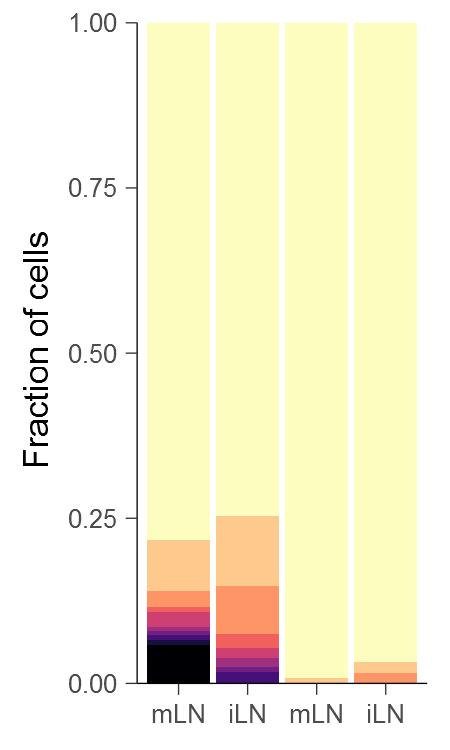

In [28]:
options(repr.plot.height = 2.5, repr.plot.width = 1.5)
g15 = ggplot(seurat2@meta.data %>% filter(!is.na(TRB_CDR3)), aes(x = sample, fill = trb_factor)) + geom_bar(position = 'fill') + guides(fill = FALSE) + theme_classic() + 
scale_y_continuous(expand = c(0,0)) +
Axis_themes + labs(x= c(), y = 'Fraction of cells') + scale_fill_manual(values = trb_size_palette) + scale_x_discrete(labels =c('mLN', 'iLN', 'mLN', 'iLN'))

g15

In [29]:
mode = function(x) {
    ret = NA
    x = x[!is.na(x)]
    x = table(x)
    x = x[order(x, decreasing = TRUE)]
    if (length(x) > 0) {
        ret = names(x)[1]
    }
    as.character(ret)
}

In [30]:
tab = table(seurat2@meta.data$TRB_CDR3, seurat2@meta.data$trbid)
rsums = rowSums(tab > 1)
rownames(tab)[rsums > 1]

[1] "CASGDWGGGDTQYF" "CASSIGDNYAEQFF" "CASSPGTGNEQYF"  "CTCSADGDTQYF"  
[5] "CTCSADGDTQYI"

In [31]:
public_clones = seurat2@meta.data %>% filter(TRB_CDR3 %in% rownames(tab)[rsums > 1])
public_clones = seurat2@meta.data %>% filter(CDR3_junction %in% public_clones$CDR3_junction)
table = public_clones %>% select(location, condition, hash, res.0.2, TRBV, TRB_CDR3, TRBJ, CDR3_junction, TRAV, TRA_CDR3, TRA_nuc, TRAJ) %>% arrange(TRB_CDR3, location, condition, hash) %>% 
group_by(location, condition, hash, CDR3_junction) %>% mutate(n = n(), TRA_CDR3 = mode(TRA_CDR3), TRAV = mode(TRAV[!is.na(TRAV)]),TRAJ = mode(TRAJ), TRA_nuc = mode(TRA_nuc), cluster = mode(res.0.2)) %>% slice(1) %>%
arrange(TRB_CDR3, location, condition, hash)

table 
write.csv(table, 'public_clones.csv', quote = FALSE)

location,condition,hash,res.0.2,TRBV,TRB_CDR3,TRBJ,CDR3_junction,TRAV,TRA_CDR3,TRA_nuc,TRAJ,n,cluster
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
Flank,tdLN,HTO5,1,TRBV13-2,CASGDWGGGDTQYF,TRBJ2-5,GCCAGCGGTGACTGGGGGGGAGGAGACACCCAGTAC,TRAV9D-4*04,CAVAGNYKYVF,TGTGCTGTGGCAGGAAACTACAAATACGTCTTT,TRAJ40*01,3,1
Lung,tdLN,HTO1,1,TRBV13-2,CASGDWGGGDTQYF,TRBJ2-5,GCCAGCGGTGACTGGGGGGGTGGAGACACCCAGTAC,TRAV1*01,NA,NA,,1,1
Lung,tdLN,HTO5,1,TRBV13-2,CASGDWGGGDTQYF,TRBJ2-5,GCCAGCGGTGATTGGGGGGGCGGGGACACCCAGTAC,TRAV1*01,NA,NA,,3,1
Flank,tdLN,HTO3,1,TRBV19,CASSIGDNYAEQFF,TRBJ2-1,GCCAGCAGTATAGGCGACAACTATGCTGAGCAGTTC,"TRAV6-5*01,TRAV6-5*02,TRAV6-5*04",CALSDWTQVVGQLTF,TGTGCTCTGAGTGATTGGACACAGGTTGTGGGGCAGCTCACTTTC,TRAJ5*01,2,1
Flank,tdLN,HTO5,1,TRBV19,CASSIGDNYAEQFF,TRBJ2-1,GCCAGCAGTATAGGGGACAACTATGCTGAGCAGTTC,TRAV1*01,NA,NA,,3,1
Lung,tdLN,HTO1,1,TRBV19,CASSIGDNYAEQFF,TRBJ2-1,GCCAGCAGTATTGGGGACAACTATGCTGAGCAGTTC,TRAV1*01,NA,NA,,2,1
Flank,tdLN,HTO1,1,TRBV12-1,CASSPGTGNEQYF,TRBJ2-7,GCCAGCTCTCCCGGGACAGGGAATGAACAGTAC,"TRAV16D/DV11*01,TRAV16N*01",CAMREYNTNTGKLTF,TGTGCTATGAGAGAGTATAACACCAATACAGGCAAATTAACCTTT,TRAJ27*01,2,1
Lung,tdLN,HTO3,0,TRBV12-1,CASSPGTGNEQYF,TRBJ2-7,GCCAGCTCTCCCGGGACAGGGAATGAACAGTAC,TRAV1*01,NA,NA,,2,0
Lung,tdLN,HTO4,3,TRBV12-1,CASSPGTGNEQYF,TRBJ2-7,GCCAGCTCCCCCGGGACAGGGAATGAACAGTAC,TRAV1*01,NA,NA,,1,3


Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



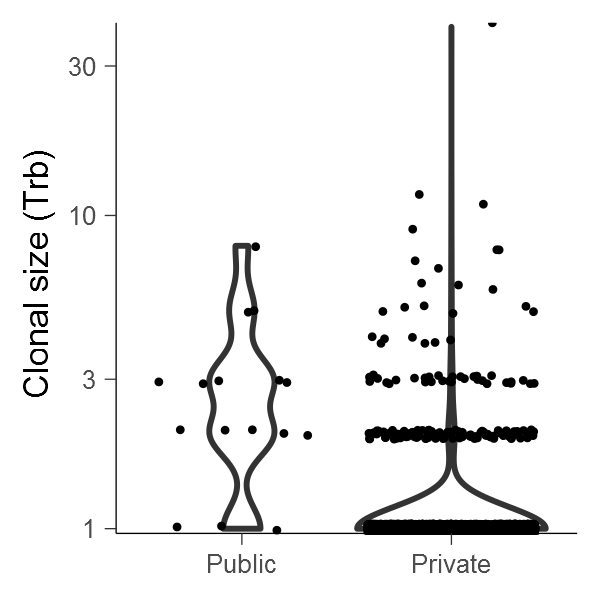

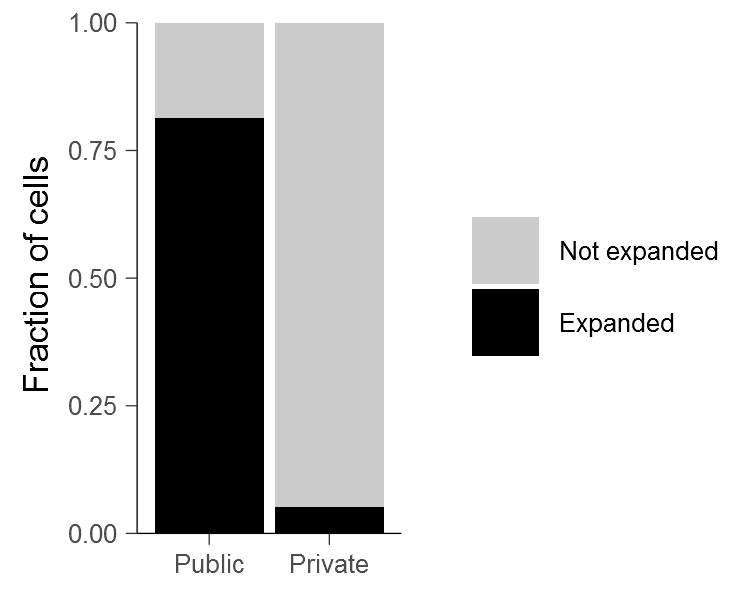

In [32]:
library(ggbeeswarm)
set.seed(1)
options(repr.plot.width = 2, repr.plot.height =2 )
seurat2@meta.data$public_clone = ifelse((seurat2@meta.data$CDR3_junction %in% table$CDR3_junction), 'Public', 'Private')
seurat2@meta.data$public_clone = factor(seurat2@meta.data$public_clone,levels =c( 'Public', 'Private'))
g16 = ggplot(seurat2@meta.data %>% filter(!is.na(TRB_CDR3))  %>% group_by(trbid) %>% slice(1), aes(x = factor(public_clone), y = trb_count)) + scale_y_log10() + geom_violin(bw = .07) + geom_jitter(size = .1) + theme_classic() + labs(x  = c(), y = 'Clonal size (Trb)')+
Axis_themes  + scale_y_log10(expand = c(0,0)) #+ stat_compare_means( comparisons = list(c(1,2)))
 
g16
options(repr.plot.width = 2.5, repr.plot.height =2 )

seurat2@meta.data$expanded = ifelse(seurat2@meta.data$trb_count > 1, 'Expanded', 'Not expanded')
seurat2@meta.data$expanded = factor(seurat2@meta.data$expanded, levels =c ('Not expanded', 'Expanded'))
g17 = ggplot(seurat2@meta.data %>% filter(!is.na(TRB_CDR3)) %>% group_by(trbid) %>% slice(1), aes(x = public_clone, fill = expanded)) + 
geom_bar(position = 'fill') + theme_classic() + Axis_themes + scale_fill_manual(values = c('grey80', 'black')) + 
labs(x = c(), y = 'Fraction of cells', fill = c()) + scale_y_continuous(expand = c(0,0))

g17

character(0)

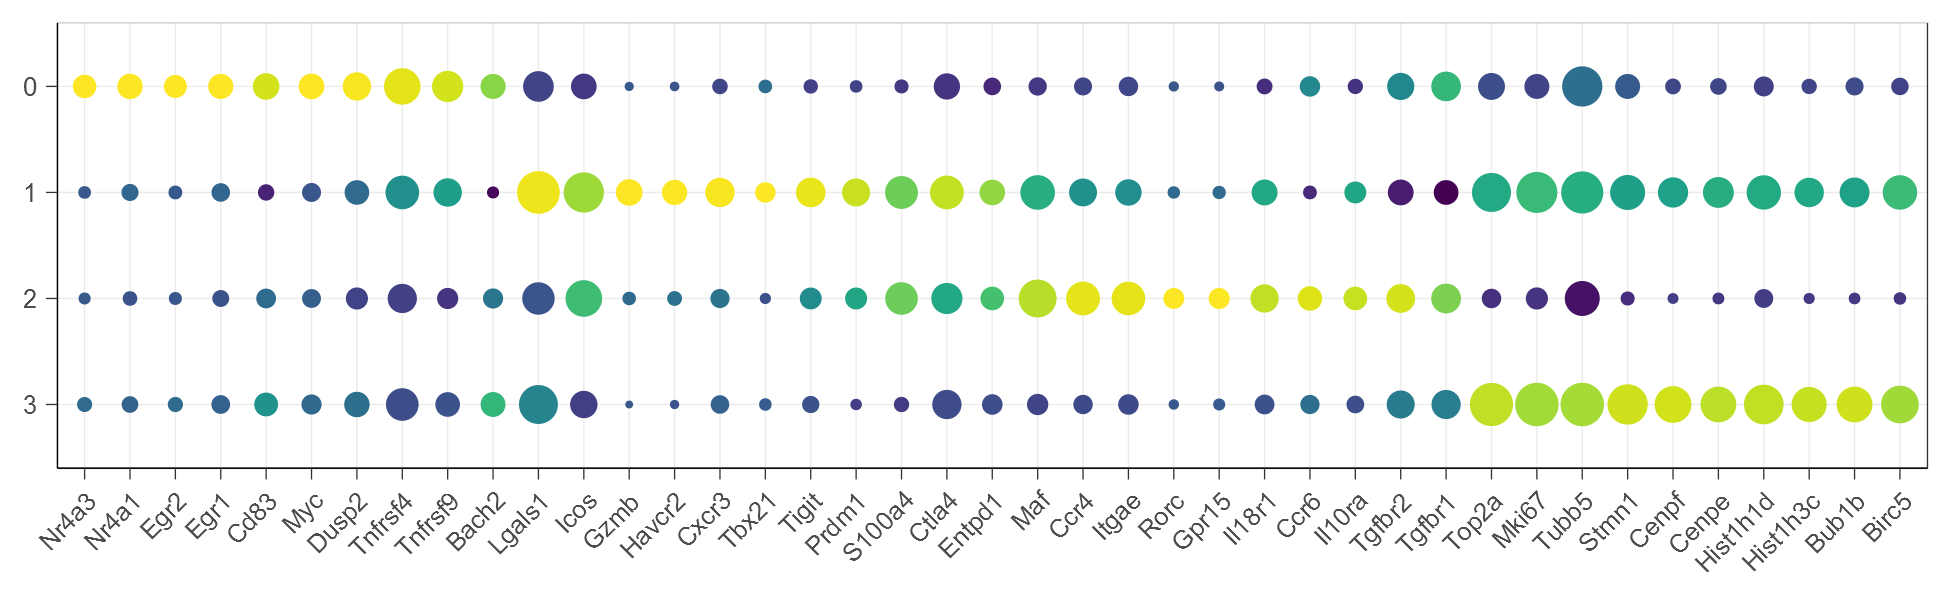

In [33]:
library(dplyr)
library(ggplot2)
genes = #c('Mki67', 'Top2a', 'Birc5', 'Ccnb2', 'Nr4a3', 'Nr4a1', 'Egr2', 'Tnfrsf4', 'Tnfrsf9')
genes = c('Nr4a3', 'Nr4a1', 'Egr2', 'Egr1', 'Cd83', 'Myc', 'Dusp2', 'Tnfrsf4', 'Tnfrsf9', 'Bach2',
         'Lgals1', 'Icos', 'Gzmb', 'Havcr2', 'Cxcr3', 'Tbx21', 'Tigit', 'Prdm1', 'S100a4', 'Ctla4', 'Entpd1', 
         'Maf', 'Ccr4', 'Itgae', 'Rorc', 'Gpr15', 'Il18r1', 'Ccr6', 'Il10ra', 'Tgfbr2', 'Tgfbr1',
         'Top2a', 'Mki67', 'Tubb5', 'Stmn1', 'Cenpf', 'Cenpe', 'Hist1h1d', 'Hist1h3c', 'Bub1b', 'Birc5')
genes[!genes %in% rownames(seurat@data)]
options(repr.plot.width = 6.5, repr.plot.height = 2, repr.plot.res =300)
pct = function(x) {
  sum(x >0)/length(x)
}
meanexp = function(x) {
    mean(x)
}
library(reshape2)
library(viridis)
data = as.data.frame(t(as.matrix(seurat2@data[genes,])))
data$phenotype = seurat2@meta.data$res.0.2
df_exp = data %>% group_by(phenotype) %>% summarize_all(.funs = list(meanexp)) %>% as.data.frame() 
df_exp[,2:(1+length(genes))] = scale(df_exp[,2:(1+length(genes))])
df_exp = df_exp %>% melt(id.vars = 'phenotype')
df_pct = data %>% group_by(phenotype) %>% summarize_all(.funs = list(pct)) %>% melt(id.vars = 'phenotype')
df_exp$value[df_exp$value > 2]= 2
df_exp$value[df_exp$value < -1.5]= -1.5
df_exp$pct = df_pct$value


lvs = levels(factor(df_exp$phenotype))
g18 = ggplot(as.data.frame(df_exp), aes(y = phenotype, x = variable, size = pct, color = value)) + geom_point() + scale_color_viridis()  + 
 theme_bw()  + theme(axis.title = element_blank(), axis.text.x = element_text(angle = 90)) + 
labs(color = "Mean expression", size = 'Fraction of cells expressing') + scale_x_discrete(limits = genes) + Axis_themes + 
theme(axis.title = element_blank(), axis.text = element_text(size = 6)) + scale_y_discrete(limits = rev(lvs)) + guides(size = FALSE, color = FALSE) +theme( axis.text.x = element_text(angle = 45, hjust = 1)) +
scale_size_continuous(range = c(0, 4)) + theme(panel.background = element_rect(size = .11671), panel.border = element_rect(size = .11671), panel.grid.major = element_line(size = .11671), panel.grid.minor = element_line(size = .11671))



g18
ggsave('markers.pdf', width = 6.2, height = 1.5, useDingbats = FALSE)

In [34]:
seurat2@meta.data$both = paste0(seurat2@meta.data$sample, seurat2@meta.data$res.0.2)
seurat2 = SetAllIdent(seurat2, 'both')

volcano_markers = FindMarkers(seurat2, c('Lung_tdLN1'), c('Flank_tdLN1'), logfc.threshold = 0)


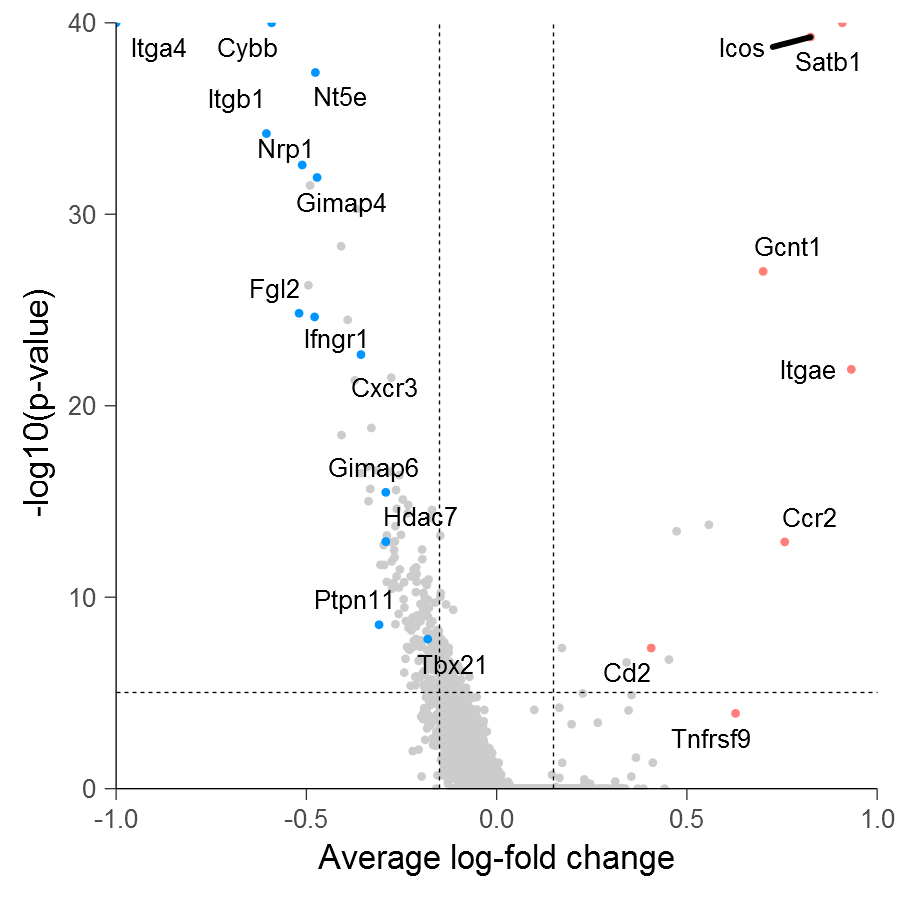

In [35]:
library(ggrepel)
options(repr.plot.width = 3, repr.plot.height = 3)
genes.to.label = c('Itga4', 'Fgl2', 'Cybb', 'Itgb1', 'Nrp1', 'Ifngr1','Gimap4', 'Nt5e', 'Gimap4', 'Cxcr3', 'Ptpn11', 'Gimap6', 'Hdac7', 'Satb1', 'Itgae', 'Icos', 'Ccr2', 'Gcnt1', 'Tnfrsf9', 'Cd2', 'Tbx21')
volcano_markers$gene = rownames(volcano_markers)
volcano_markers$gene[!rownames(volcano_markers) %in% genes.to.label] = NA
volcano_markers$color = 'a'
volcano_markers$color[!is.na(volcano_markers$gene) & volcano_markers$avg_logFC > 0] = 'b'
volcano_markers$color[!is.na(volcano_markers$gene) & volcano_markers$avg_logFC < 0] = 'c'

volcano_markers$pval_plot = ifelse(volcano_markers$p_val_adj < 1e-40, 1e-40, volcano_markers$p_val_adj)
volcano_markers$avg_logFC_plot = volcano_markers$avg_logFC
volcano_markers$avg_logFC_plot[volcano_markers$avg_logFC > 1] = 1

g20 = ggplot(volcano_markers %>% filter(is.na(gene)), aes(x = -avg_logFC_plot, y = -log10(pval_plot), color = color)) + geom_point(size = .1) + 
geom_point(data = volcano_markers %>% filter(!is.na(gene)),  aes(x = -avg_logFC_plot, y = -log10(pval_plot), color = color), size = .1) + 
geom_text_repel(data = volcano_markers %>% filter(!is.na(gene)), aes(label = gene), size = 2.1167, color = 'black') + 
theme_classic() + Axis_themes + guides(color = FALSE) + scale_x_continuous(limits = c(-1, 1), expand = c(0,0)) + 
scale_color_manual(values = c('grey80', tissue_palette[4], tissue_palette[2])) + scale_y_continuous(expand = c(0,0)) + 
geom_hline(yintercept = 5, linetype = 'dashed', size = .1167) + geom_vline(xintercept = .15, linetype = 'dashed', size = .1167) + 
geom_vline(xintercept = -.15, linetype = 'dashed', size = .1167) + labs(x = 'Average log-fold change', y = '-log10(p-value)')


g20 
ggsave('volcano_plot.pdf', height =2.5, width = 2.5, useDingbats = FALSE)



In [36]:
write.csv(volcano_markers, 'volcano_genes.csv')

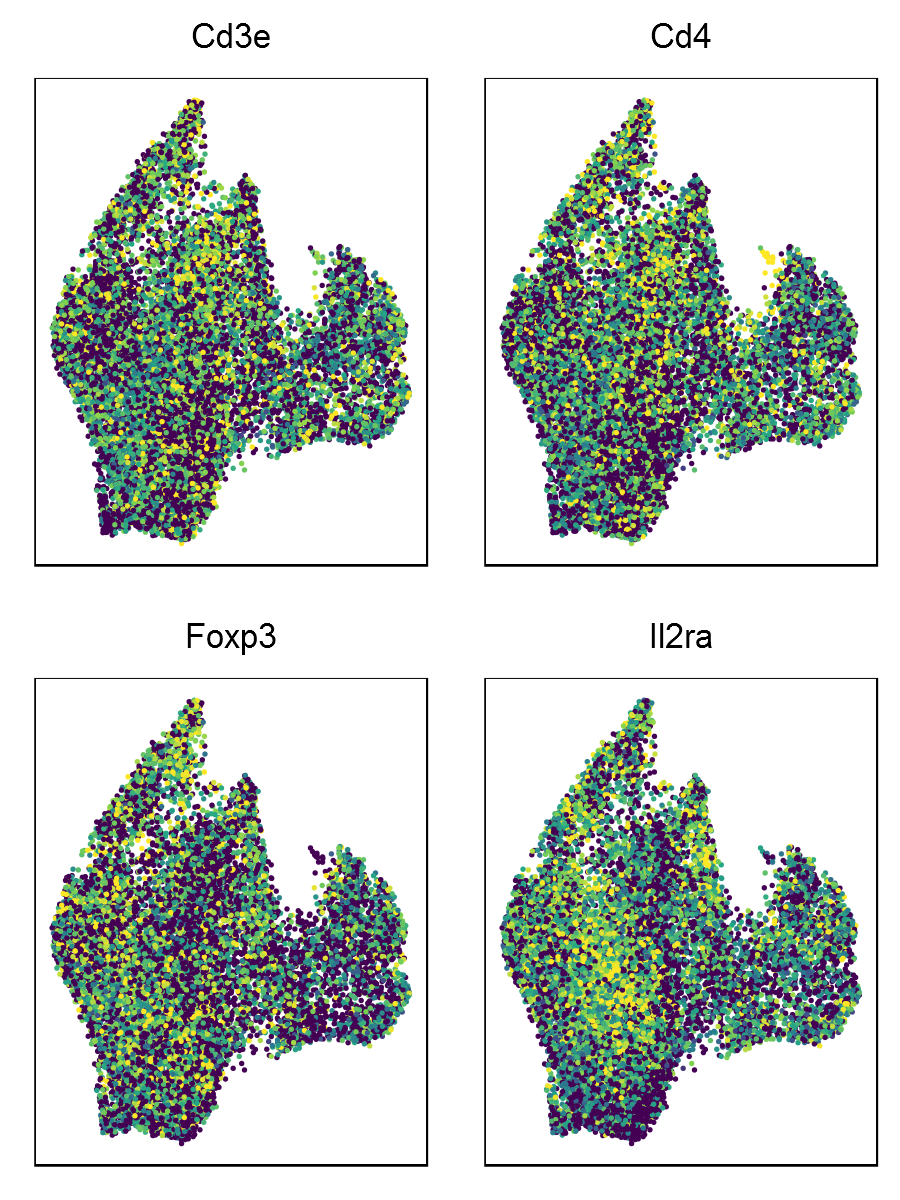

In [37]:
library(viridis)
options(repr.plot.height = 4)

geneplot = function (seurat, genes) 
{
    plots = c()
    for (curr in genes) {
        seurat@meta.data$gene = seurat@data[curr, rownames(seurat@meta.data)]
        up = quantile(seurat@meta.data$gene, .95)
        seurat@meta.data$gene[seurat@meta.data$gene > up] = up
        plots[[curr]] = ggplot(shuffle(seurat@meta.data), aes(x = UMAP1, 
            y = UMAP2, color = gene)) + geom_point(size = 0.5, stroke = 0) + UMAP_theme +
            scale_color_viridis_c() + labs(title = curr) + guides(color = FALSE) +
            theme(axis.title = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), plot.title = element_text(hjust = .5, size = 8))
    }
    gg = plot_grid(plotlist = plots)
    gg
}

g22=geneplot(seurat, c('Cd3e', 'Cd4', 'Foxp3', 'Il2ra'))
g22
#ggsave('foxp3plots.pdf', useDingbats = FALSE, height =3, width = 3)

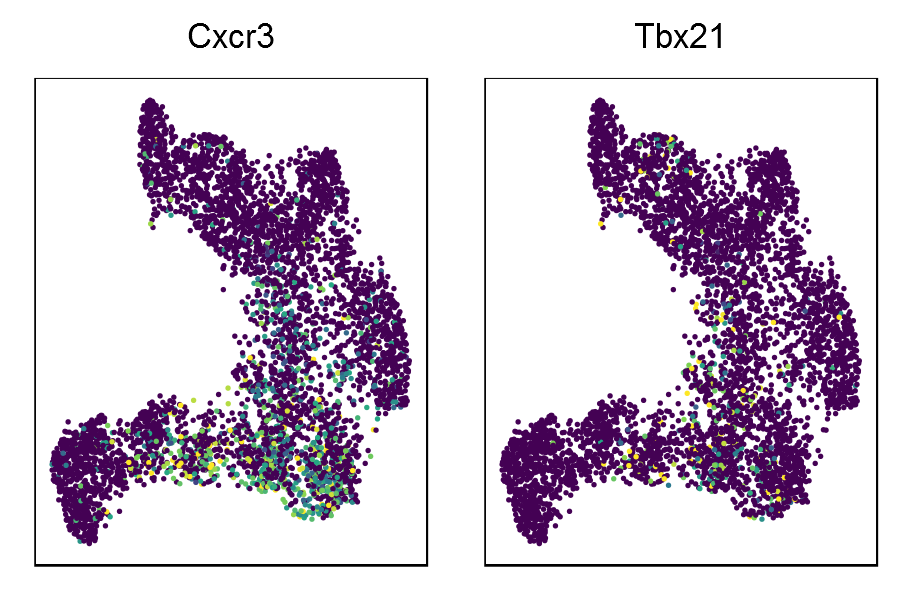

In [38]:
options(repr.plot.height = 2, repr.plot.res = 300)
geneplot = function (seurat, genes) 
{
    plots = c()
    for (curr in genes) {
        seurat@meta.data$gene = seurat@data[curr, rownames(seurat@meta.data)]
        up = quantile(seurat@meta.data$gene, .99)
        seurat@meta.data$gene[seurat@meta.data$gene > up] = up
        plots[[curr]] = ggplot(shuffle(seurat@meta.data), aes(x = UMAP1, 
            y = UMAP2, color = gene)) + geom_point(size = 0.5, stroke = 0) + UMAP_theme +
            scale_color_viridis_c() + labs(title = curr) + guides(color = FALSE) +
            theme(axis.title = element_blank(), axis.text = element_blank(), axis.ticks = element_blank(), plot.title = element_text(hjust = .5, size = 8))
    }
    gg = plot_grid(plotlist = plots)
    gg
}

g23 = geneplot(seurat2, c('Cxcr3', 'Tbx21'))
g23
ggsave('tbetplot.pdf', useDingbats = FALSE, height = 1.5, width = 3)

In [39]:
write.csv(seurat@meta.data, 'metadata.csv', sep = '\t')

Warning message in write.csv(seurat@meta.data, "metadata.csv", sep = "\t"):
"attempt to set 'sep' ignored"


In [40]:
sessionInfo()

R version 3.6.3 (2020-02-29)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows Server x64 (build 14393)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggrepel_0.8.2      ggbeeswarm_0.6.0   viridis_0.5.1      viridisLite_0.4.0 
 [5] reshape2_1.4.4     ggpubr_0.2.5       magrittr_2.0.1     stringr_1.4.0     
 [9] GSA_1.03.1         fgsea_1.12.0       Rcpp_1.0.8         dplyr_1.0.9       
[13] feather_0.3.5      RColorBrewer_1.1-2 ggthemes_4.2.4     Seurat_2.3.4      
[17] Matrix_1.2-18      cowplot_1.0.0      ggplot2_3.3.0     

loaded via a namespace (and not attached):
  [1] uuid_0.1-4          snow_0.4-3          backports_1.1.6    
  [4] fast